In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM,GRU , MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

<ipython-input-9-9dd469a3f9cb>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [10]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

<ipython-input-10-f391b7cb3b7b>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [12]:
trainy = trainy - 3
testy = testy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# GRU1

In [16]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               106752    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 140035 (547.01 KB)
Trainable params: 140035 (547.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 17s 80ms/step - loss: 0.5323 - accuracy: 0.7849 - val_loss: 0.2780 - val_accuracy: 0.8706
Epoch 2/10
32/32 [==============================] - 1s 34ms/step - loss: 0.2489 - accuracy: 0.8911 - val_loss: 0.2339 - val_accuracy: 0.8821
Epoch 3/10
32/32 [==============================] - 1s 25ms/step - loss: 0.2348 - accuracy: 0.9034 - val_loss: 0.2104 - val_accuracy: 0.9115
Epoch 4/10
32/32 [==============================] - 1s 25ms/step - loss: 0.2244 - accuracy: 0.9051 - val_loss: 0.2798 - val_accuracy: 0.8845
Epoch 5/10
32/32 [==============================] - 1s 23ms/step - loss: 0.2322 - accuracy: 0.9058 - val_loss: 0.2130 - val_accuracy: 0.9271
Epoch 6/10
32/32 [==============================] - 1s 23ms/step - loss: 0.2238 - accuracy: 0.9063 - val_loss: 0.2294 - val_accuracy: 0.9230
Epoch 7/10
32/32 [==============================] - 1s 20ms/step - loss: 0.2175 - accuracy: 0.9075 - val_loss: 0.2059 - val_accuracy: 0.8984
Epoch 8/10
3

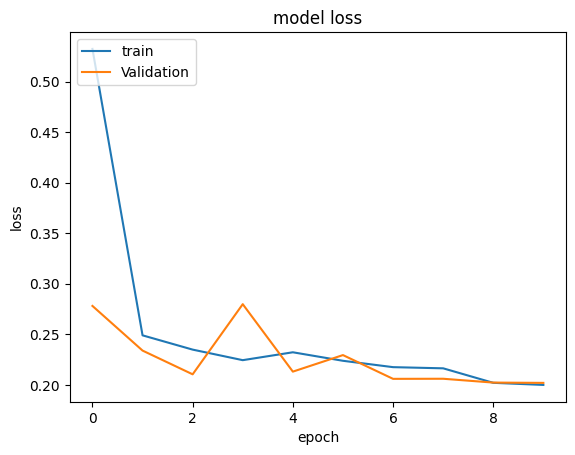

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

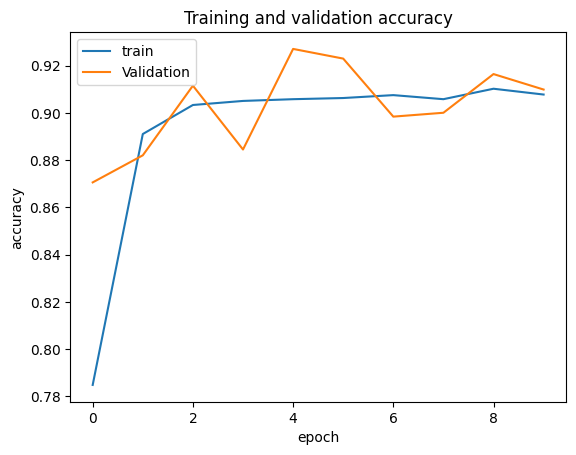

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 8ms/step
[[374 117   0]
 [ 61 471   0]
 [  0   0 537]]
0.8858974358974359
0.8852998144763803
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       491
           1       0.80      0.89      0.84       532
           2       1.00      1.00      1.00       537

    accuracy                           0.89      1560
   macro avg       0.89      0.88      0.88      1560
weighted avg       0.89      0.89      0.89      1560



<Axes: >

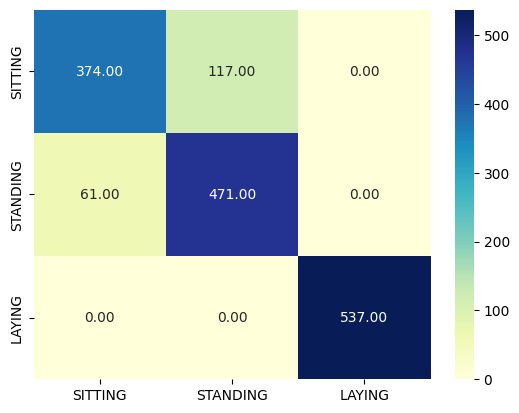

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDING','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 2


In [21]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 3)                

In [22]:

# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 9s 80ms/step - loss: 0.4548 - accuracy: 0.7994 - val_loss: 0.2800 - val_accuracy: 0.8583
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.2525 - accuracy: 0.8925 - val_loss: 0.2376 - val_accuracy: 0.9238
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.2281 - accuracy: 0.9029 - val_loss: 0.2062 - val_accuracy: 0.9075
Epoch 4/10
32/32 [==============================] - 1s 40ms/step - loss: 0.2184 - accuracy: 0.9024 - val_loss: 0.2310 - val_accuracy: 0.8862
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.2121 - accuracy: 0.9085 - val_loss: 0.2054 - val_accuracy: 0.9189
Epoch 6/10
32/32 [==============================] - 1s 40ms/step - loss: 0.2170 - accuracy: 0.9088 - val_loss: 0.2162 - val_accuracy: 0.8927
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.2172 - accuracy: 0.9075 - val_loss: 0.2024 - val_accuracy: 0.9214
Epoch 8/10
32

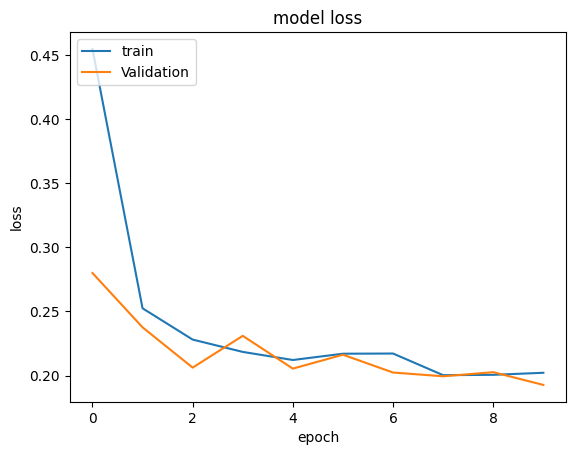

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

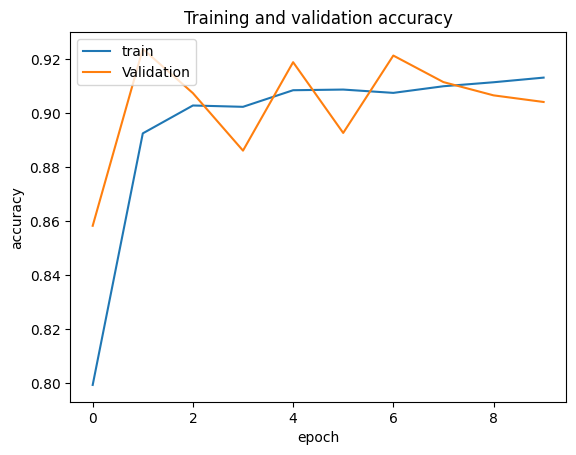

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 2s 12ms/step
[[380 106   5]
 [ 80 452   0]
 [  0   0 537]]
0.8775641025641026
0.8769980093065258
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       491
           1       0.81      0.85      0.83       532
           2       0.99      1.00      1.00       537

    accuracy                           0.88      1560
   macro avg       0.88      0.87      0.87      1560
weighted avg       0.88      0.88      0.88      1560



<Axes: >

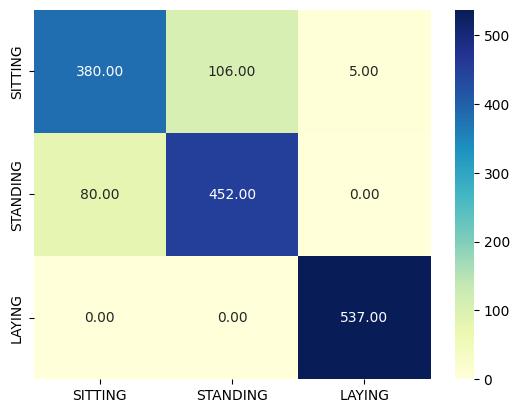

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDING','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 3

In [26]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                      

In [27]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 14s 127ms/step - loss: 0.4303 - accuracy: 0.8077 - val_loss: 0.2455 - val_accuracy: 0.8829
Epoch 2/10
32/32 [==============================] - 2s 62ms/step - loss: 0.2333 - accuracy: 0.9009 - val_loss: 0.2158 - val_accuracy: 0.8829
Epoch 3/10
32/32 [==============================] - 2s 66ms/step - loss: 0.2230 - accuracy: 0.9041 - val_loss: 0.2113 - val_accuracy: 0.9214
Epoch 4/10
32/32 [==============================] - 2s 62ms/step - loss: 0.2141 - accuracy: 0.9053 - val_loss: 0.2131 - val_accuracy: 0.9238
Epoch 5/10
32/32 [==============================] - 2s 63ms/step - loss: 0.2304 - accuracy: 0.9039 - val_loss: 0.2960 - val_accuracy: 0.8714
Epoch 6/10
32/32 [==============================] - 2s 68ms/step - loss: 0.2321 - accuracy: 0.9026 - val_loss: 0.2077 - val_accuracy: 0.9091
Epoch 7/10
32/32 [==============================] - 2s 66ms/step - loss: 0.2208 - accuracy: 0.9093 - val_loss: 0.2095 - val_accuracy: 0.9165
Epoch 8/10


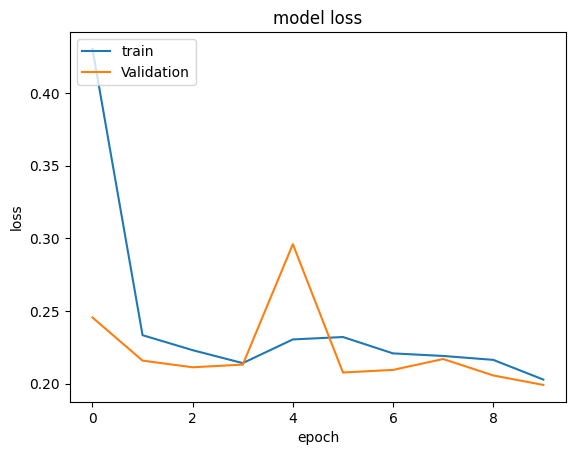

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

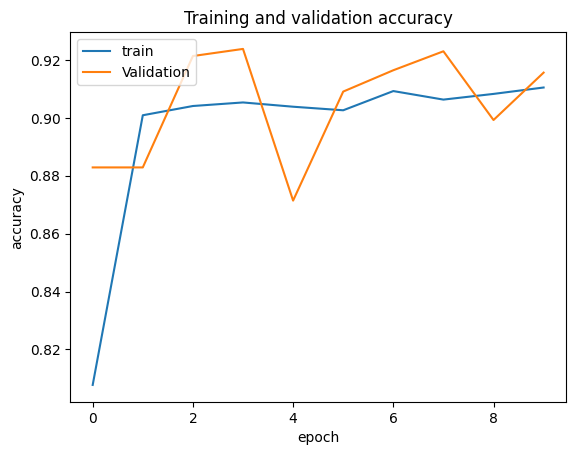

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 3s 16ms/step
[[378 109   4]
 [ 87 445   0]
 [  0   0 537]]
0.8717948717948718
0.8713288608418607
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       491
           1       0.80      0.84      0.82       532
           2       0.99      1.00      1.00       537

    accuracy                           0.87      1560
   macro avg       0.87      0.87      0.87      1560
weighted avg       0.87      0.87      0.87      1560



<Axes: >

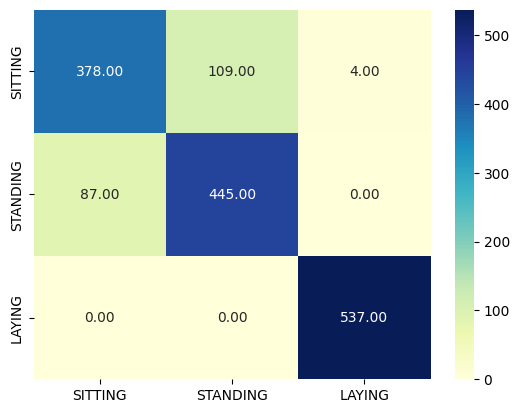

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDING','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU4

In [31]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                      

In [32]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 20s 167ms/step - loss: 0.3955 - accuracy: 0.8289 - val_loss: 0.2761 - val_accuracy: 0.8747
Epoch 2/10
32/32 [==============================] - 3s 85ms/step - loss: 0.2612 - accuracy: 0.8886 - val_loss: 0.2286 - val_accuracy: 0.9263
Epoch 3/10
32/32 [==============================] - 3s 87ms/step - loss: 0.2476 - accuracy: 0.8940 - val_loss: 0.2304 - val_accuracy: 0.8829
Epoch 4/10
32/32 [==============================] - 3s 89ms/step - loss: 0.2096 - accuracy: 0.9137 - val_loss: 0.2255 - val_accuracy: 0.8804
Epoch 5/10
32/32 [==============================] - 3s 87ms/step - loss: 0.2271 - accuracy: 0.9071 - val_loss: 0.2304 - val_accuracy: 0.8886
Epoch 6/10
32/32 [==============================] - 3s 86ms/step - loss: 0.2179 - accuracy: 0.9085 - val_loss: 0.2060 - val_accuracy: 0.9115
Epoch 7/10
32/32 [==============================] - 3s 87ms/step - loss: 0.2128 - accuracy: 0.9112 - val_loss: 0.2341 - val_accuracy: 0.9066
Epoch 8/10


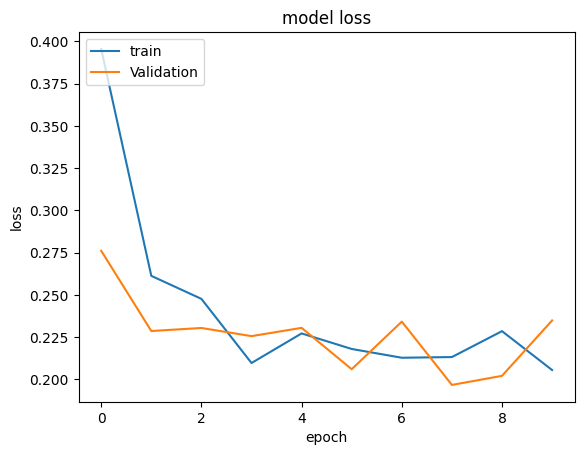

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

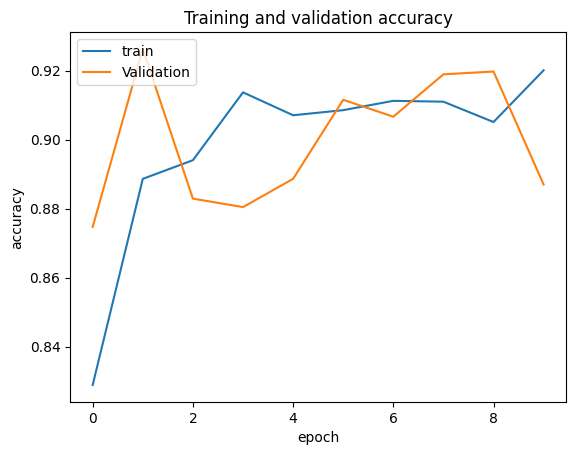

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 4s 25ms/step
[[361 110  20]
 [ 47 485   0]
 [  0   0 537]]
0.8865384615384615
0.8842309415652108
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       491
           1       0.82      0.91      0.86       532
           2       0.96      1.00      0.98       537

    accuracy                           0.89      1560
   macro avg       0.89      0.88      0.88      1560
weighted avg       0.89      0.89      0.88      1560



<Axes: >

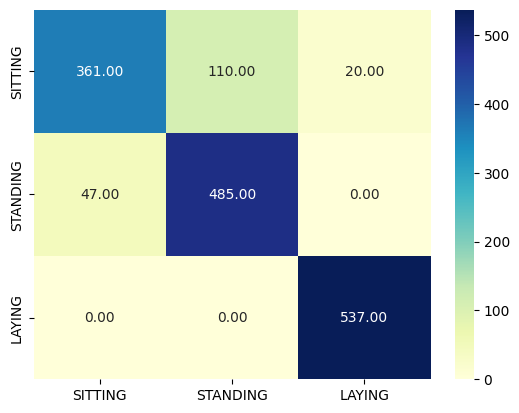

In [35]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDING','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 5

In [36]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 128, 256)          106752    
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_11 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_12 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                      

In [37]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 23s 201ms/step - loss: 0.4094 - accuracy: 0.8215 - val_loss: 0.2238 - val_accuracy: 0.8878
Epoch 2/10
32/32 [==============================] - 4s 117ms/step - loss: 0.2787 - accuracy: 0.8847 - val_loss: 0.3097 - val_accuracy: 0.8739
Epoch 3/10
32/32 [==============================] - 3s 107ms/step - loss: 0.2567 - accuracy: 0.8901 - val_loss: 0.2625 - val_accuracy: 0.8780
Epoch 4/10
32/32 [==============================] - 3s 107ms/step - loss: 0.2336 - accuracy: 0.9031 - val_loss: 0.2344 - val_accuracy: 0.9148
Epoch 5/10
32/32 [==============================] - 4s 116ms/step - loss: 0.2451 - accuracy: 0.8923 - val_loss: 0.2688 - val_accuracy: 0.8788
Epoch 6/10
32/32 [==============================] - 3s 110ms/step - loss: 0.2351 - accuracy: 0.9029 - val_loss: 0.2098 - val_accuracy: 0.9001
Epoch 7/10
32/32 [==============================] - 3s 109ms/step - loss: 0.2140 - accuracy: 0.9071 - val_loss: 0.2061 - val_accuracy: 0.9156
Epoch

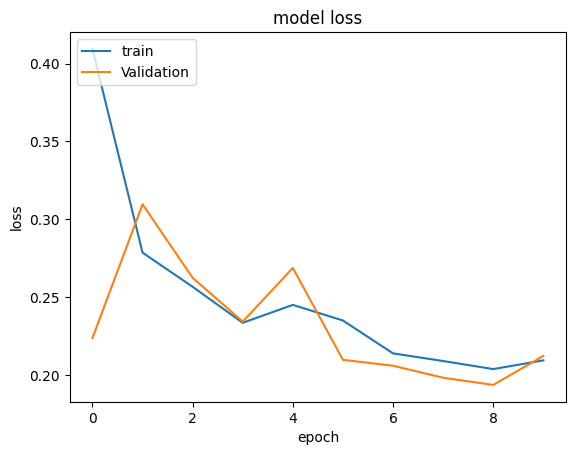

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

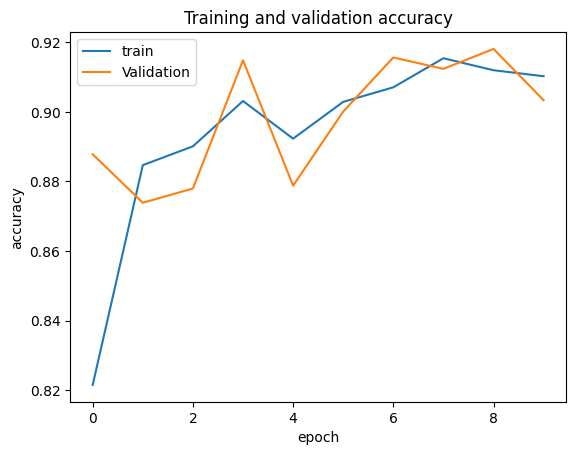

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 4s 21ms/step
[[414  72   5]
 [ 65 467   0]
 [  0   0 537]]
0.908974358974359
0.9087057350663964
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       491
           1       0.87      0.88      0.87       532
           2       0.99      1.00      1.00       537

    accuracy                           0.91      1560
   macro avg       0.91      0.91      0.91      1560
weighted avg       0.91      0.91      0.91      1560



<Axes: >

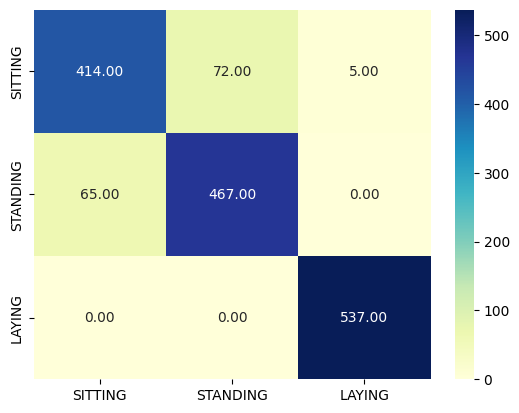

In [40]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDING','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')